# SQUANCH demonstration: superdense coding

In [1]:
import numpy as np
import time 
import matplotlib.image as image
import matplotlib.pyplot as plt
from squanch import *

$\newcommand{\ket}[1]{\lvert #1 \rangle}$

This Jupyter notebook contains the source code for the [superdense coding demonstration](https://att-innovate.github.io/squanch/demos/superdense-coding.html). Refer to the documentation for more detailed explanations. 

Superdense coding is a process whereby two parties connected via a quantum channel and sharing an entangled pair can send two classical bits of information using only a single qubit. Conceptually, superdense coding is the inverse of quantum teleportation. 

In this demonstration, we'll implement the three-party superdense coding protocol depicted in the circuit diagram shown below. Charlie distributes entangled particles to Alice and Bob. Alice encodes her information in her particles and sends them to Bob, who decodes the information by matching Alice’s qubits with his half of the shared state received from Charlie. More precisely:

1. Charlie generates entangled pairs in the state $\ket{AB} = \frac{1}{\sqrt{2}}\left(\ket{00}+\ket{11}\right)$ and sends one particle to Alice and the other to Bob.
2. Alice has a number of bits she wishes to send to Bob. For each pair, she encodes her two bits $b_1$ and $b_2$ in the relative sign and phase of her qubit by conditionally applying $\sigma_z$ and $\sigma_x$, respectively. She then sends the modified qubit to Bob.
3. Bob disentangles the X and Z components of the qubit by applying $\mathrm{CNOT}$ and $H$ to Alice’s qubit and Charlie’s qubit. He then measures each of Alice’s and Charlie’s qubits to obtain $b_1$ and $b_2$, respectively.

![Superdense coding circuit](../docs/source/img/superdense-circuit.png)

For this demonstration, Alice will send data to Bob in the form of a serialized bitstream representing an image. We'll use the built-in timing functionality to track the simulated time for each agent to complete their part of the protocol. Since superdense coding could be used as a networking protocol in the foreseeable future, even very rudimentary simulated timing data could be useful to quantify the performance of the algorithm, especially if data validation and error correction through multiple transmission attempts is simulated. We assume a photon pulse interval of 1ns and a spatial separation between Alice and Bob of 1km, with Charlie at the midpoint. All agents are connected with the $\texttt{FiberOpticQChannel}$ model, which simulates $0.16\frac{\mathrm{dB}}{\mathrm{km}}$ attenuation errors by randomly changing transmitted $\texttt{Qubit}$s to $\texttt{None}$. Any dropped qubits lost to attenuation will have their bits replaced with 0.

In [2]:
class Charlie(Agent):
    '''Charlie distributes Bell pairs between Alice and Bob.'''
    def run(self):
        for qsys in self.qstream:
            a, b = qsys.qubits
            H(a)
            CNOT(a, b)
            self.qsend(alice, a)
            self.qsend(bob, b)
        self.output({"t": self.time})

In [3]:
class Alice(Agent):
    '''Alice sends information to Bob via superdense coding'''
    def run(self):
        for _ in self.qstream:
            bit1 = self.data.pop(0)
            bit2 = self.data.pop(0)
            q = self.qrecv(charlie)
            if q is not None: # qubit could be lost due to attenuation errors
                if bit2 == 1: X(q)
                if bit1 == 1: Z(q)
            self.qsend(bob, q)
        self.output({"t": self.time})

In [4]:
class Bob(Agent):
    '''Bob receives Alice's transmissions and reconstructs her information'''
    def run(self):
        bits = []
        for _ in self.qstream:
            a = self.qrecv(alice)
            c = self.qrecv(charlie)
            if a is not None and c is not None:
                CNOT(a, c)
                H(a)
                bits.extend([a.measure(), c.measure()])
            else:
                bits.extend([0,0])
        self.output({"t": self.time, "bits": bits})

## Running the simulation

In [6]:
# Load an image and serialize it to a bitstream
img = image.imread("../docs/source/img/foundryLogo.bmp") 
bitstream = list(np.unpackbits(img))

# Initialize the qstream
qstream = QStream(2, int(len(bitstream) / 2))

# Make agent instances
out = Agent.shared_output()
alice = Alice(qstream, out, data = bitstream)
bob = Bob(qstream, out)
charlie = Charlie(qstream, out)

# Set photon transmission rate
alice.pulse_length = 1e-9
bob.pulse_length = 1e-9
charlie.pulse_length = 1e-9

# Connect the agents with simulated fiber optic lines; see squanch.channels module
alice.qconnect(bob, FiberOpticQChannel, length=1.0)
charlie.qconnect(alice, FiberOpticQChannel, length=0.5)
charlie.qconnect(bob, FiberOpticQChannel, length=0.5)




Transmitted 2 bits in 72.041s.
Simulated time: Alice: 4.16e-04s, Bob: 4.20e-04s, Charlie: 4.15e-04s


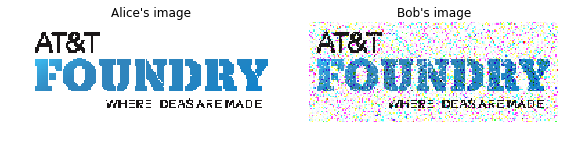

In [7]:
# Run the agents
start = time.time()
Simulation(alice, bob, charlie).run()

print("Transmitted {} bits in {:.3f}s.".format(len(out["Bob"]), time.time() - start))
t_alice, t_bob, t_charlie = out["Alice"]["t"], out["Bob"]["t"], out["Charlie"]["t"]
print("Simulated time: Alice: {:.2e}s, Bob: {:.2e}s, Charlie: {:.2e}s"
      .format(t_alice, t_bob, t_charlie))
received = np.reshape(np.packbits(out["Bob"]["bits"]), img.shape)
f, ax = plt.subplots(1, 2, figsize = (8, 4))
ax[0].imshow(img)
ax[0].axis('off')
ax[0].title.set_text("Alice's image")
ax[1].imshow(received)
ax[1].axis('off')
ax[1].title.set_text("Bob's image")
plt.tight_layout()
plt.show()

In [ ]:
print("Simulated time: Alice: {:.2e}s, Bob: {:.2e}s, Charlie: {:.2e}s"
      .format(t_alice, t_bob, t_charlie))